In [1]:
%load_ext tikzmagic

---
slug: "/blog/decisiontrees"
date: "2021-03-15"
title: "Decision Trees"
category: "1 Machine Learning"
order: 5
---

### Introduction

Decision trees are a non-parametric regression and classification method that can be used to estimate categorical and real-valued output given real-valued input vectors. 
In this post, the "Classification and Regression Trees" (CART) approach will be used to build trees.
The maximum depth as well as minimum leaf size will be considered parameters of the tree.
Cost-complexity pruning will not be examined for the purposes of this post.

The input table and decision tree below show how a learned decision tree works.
In this classification example, the input is classified as "Iris Versicolor" due to the "Sepal Length" feature being less than $6.0$ and the "Sepal Width" feature being $\geq 3.0$.
Classification and regression using decision trees is calculated by taking and input and traversing the tree until a leaf node is reached.

|Sepal Length|Sepal Width|Petal Length|
|:----------:|:---------:|:----------:|
|5.84|3.05|3.76|

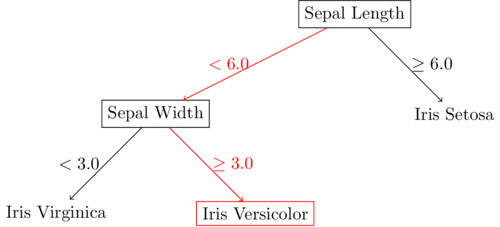

In [2]:
%%tikz -s=500,300 -sc=2
\node[draw, rectangle] (a) at (3, 2) {Sepal Length};
\node[draw, rectangle] (b) at (1, 1) {Sepal Width};
\node (c) at (4, 1) {Iris Setosa};
\node[draw=red, rectangle] (d) at (2, 0) {Iris Versicolor};
\node (e) at (0, 0) {Iris Virginica};
\draw[->, red] (a) edge node[left] {$< 6.0$} (b);
\draw[->] (a) edge node[right] {$\geq 6.0$} (c);
\draw[->, red] (b) edge node[right] {$\geq 3.0$} (d);
\draw[->] (b) edge node[left] {$< 3.0$} (e);

Decision trees are learned by recursively splitting the data set until a parameter setting is met (the maximum depth has been reached, or the data set contains fewer elements than the required minimum leaf size), or if features are examined without replacement, until there are no more features left to be split on.
At each split, a feature and value pair is chosen that separates the data most effectively.
Determining the effectiveness of a split can be done in multiple ways.
For the purposes of this post, for a decision tree regressor, splitting is performed using mean squared error, and for a decision tree classifier, splitting is performed using the gini index.

### Learning: Regression

Given data set $X$, a split is chosen resulting in 2 subsets of $X$, $R_1$ and $R_2$ such that the sum of mean squared errors of $R_1$ and $R_2$ are minimized

$$
\begin{aligned}
    R_m &= \text{Node } m & \\
    N_m &= \#\{x_i \in R_m\} & \text{[Size of data in $R_m$]}\\
    j &= \text{attribute} &\\
    a &= \text{value} &\\
    c_m &= \frac{1}{N_m}\sum^{N_m}_{i=1}y_{m, i} & \text{[Output for $R_m$]}\\
    j, s &= \min_{j, s} \left[
       \min_{c_1} \frac{1}{N_1}\sum^{N_1}_{i=1} (y_{1, i} - c_1)^2 +
       \min_{c_2} \frac{1}{N_2}\sum^{N_2}_{i=1} (y_{2, i} - c_1)^2
    \right]&\text{[Mean squared error splitting condition]}
\end{aligned}
$$

### Code

Code for a decision tree regressor is shown in the block below

In [3]:
from typing import List
import torch


class Node:

    def __init__(self, left=None, right=None, attribute: int=None, value: float=None, label: float=None) -> None:
        """ Instantiate member of Node class

        Args:
            left: left child
            right: right child
            attribute: column of dataset to split on
            value: value of attribute to split on
            label: majority class label at this node
            counts: frequency of each class at this node
        """
        self.right, self.left = right, left
        self.attribute = attribute
        self.value = value
        self.label = label


def MeanSquaredError(y: torch.Tensor, yhat: torch.Tensor) -> float:
    """ Calculate mean squared error rate

    Args:
        y: true labels
        yhat: predicted labels

    Returns:
        mean squared error        
    """

    return torch.sum((y - yhat)**2) / y.shape[0]


class DecisionTreeRegressor:


    def __init__(self, maxDepth: int=None, leafSize: int=1) -> None:
        """ Instantiate member of DecisionTreeClassifier class


        Args:
            maxDepth: maximum depth to allow when building tree
            leafSize: minimum number of members required to split a node 
        """
        self.maxDepth = maxDepth
        self.leafSize = leafSize
        self.root = None


    def fit(self, x: torch.Tensor, y: torch.Tensor) -> None:
        """ Fit decision tree to dataset

        Args:
            x: training data
            y: labels corresponding to x
        """
        self.root = self.buildTree(x, y, leafSize=self.leafSize, maxDepth=self.maxDepth)


    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """ Predict label given input

        Args:
            x: input data

        Returns:
            tensor of predicted labels
        """

        y = []
        for ridx in range(x.shape[0]):
            
            curnode = self.root 
            while not (curnode.left is None and curnode.right is None):
                if x[ridx, curnode.attribute] <= curnode.value: curnode = curnode.left
                else: curnode = curnode.right

            y.append(curnode.label)            
        return torch.Tensor(y)


    def splitValue(self, x: torch.Tensor, y: torch.Tensor, attribute: int) -> (float, float):
        """ Determine best split value given an attribute

        Args
            x: input dataset
            y: input dataset labels
            attribute: column to find best split value on

        Returns:
            the best split value and the mean squared error of the split at that
            value
        """

        mins, minval = None, float("inf")
        for sidx in range(self.leafSize, x.shape[0]):

            if x[sidx, attribute] != x[sidx-1, attribute]:
                c1 = torch.mean(y[:sidx])
                c2 = torch.mean(y[sidx:])
                mse = (MeanSquaredError(y[:sidx], c1) + MeanSquaredError(y[sidx:], c2)).item()

                if mse < minval:
                    mins = ((x[sidx-1, attribute] + x[sidx, attribute]) / 2).item()
                    minval = mse

        return mins, minval
                

    def splitAttributeValue(self, x: torch.Tensor, y: torch.Tensor) -> (int, float, float):
        """ Given a dataset, return best (attribute, value) pair to split on

        Args:
            x: input dataset
            y: input dataset labels

        Returns:
            attribute to split on, attribute value to split on, and mean squared
            error at that split
        """

        # Find best split attribute, value
        minj, mins, minval = None, None, float("inf")
        for j in range(x.shape[1]):
            
            xargs = torch.argsort(x[:, j])
            x, y = x[xargs], y[xargs]
            s, val = self.splitValue(x, y, j)

            if val < minval:
                minj = j
                mins = s
                minval = val

        return minj, mins, minval


    def buildTree(self, x: torch.Tensor, y: torch.Tensor, depth: int=0, maxDepth: int=None, leafSize: int=1) -> Node:
        """ Build decision tree given a dataset

        Args:
            x: input dataset
            y: input dataset labels
            depth: depth of current node
            maxDepth: maximum allowed depth of tree
            leafSize: minimum required members of node for split

        Returns:
            root node of tree
        """

        if (x.shape[0] <= leafSize) or (maxDepth is not None and depth==maxDepth):
            label = torch.mean(y)
            return Node(label=label)

        else:

            attribute, value, mse = self.splitAttributeValue(x, y)

            if value is None:
                label = torch.mean(y)
                return Node(label=label)

            else:
                largs = (x[:, attribute] <= value)
                rargs = (x[:, attribute] > value)
                left = self.buildTree(x[largs], y[largs], depth+1, maxDepth, leafSize)
                right = self.buildTree(x[rargs], y[rargs], depth+1, maxDepth, leafSize)
                return Node(left, right, attribute, value)

### Learning: Classification

Given data set $X$, a split is chosen resulting in 2 subsets of $X$, $R_1$ and $R_2$ such that the sum of gini index values of $R_1$ and $R_2$ are minimized

$$
\begin{aligned}
    R_m &= \text{Node } m & \\
    N_m &= \#\{x_i \in R_m\} & \text{[Size of data in $R_m$]}\\
    j &= \text{attribute} &\\
    a &= \text{value} &\\
    p_{m, k} &= \frac{1}{N_m}\sum^{N_m}_{i=1} I(y_{m, i} = k) &\text{[Probability of class $k$ in $R_m$]}\\
    c_m &= \max_k p_{m, k} & \text{[Output for $R_m$]}\\
    j, s &= \min_{j, s} \left[
        N_1 \sum^{K}_{k=1} p_{1, k} \log (1 - p_{1, k}) +
        N_2 \sum^{K}_{k=1} p_{2, k} \log (1 - p_{2, k})
    \right]&\text{[Gini index splitting condition]}
\end{aligned}
$$

### Code

Code for a decision tree classifier is shown in the block below

In [4]:
from typing import List
import torch


class Node:

    def __init__(self, left=None, right=None, attribute: int=None, value: float=None, label: float=None) -> None:
        """ Instantiate member of Node class

        Args:
            left: left child
            right: right child
            attribute: column of dataset to split on
            value: value of attribute to split on
            label: majority class label at this node
            counts: frequency of each class at this node
        """
        self.right, self.left = right, left
        self.attribute = attribute
        self.value = value
        self.label = label


class DecisionTreeClassifier:

    def __init__(self, maxDepth: int=None, leafSize: int=1) -> None:
        """ Instantiate member of DecisionTreeClassifier class


        Args:
            maxDepth: maximum depth to allow when building tree
            leafSize: minimum number of members required to split a node 
        """
        self.maxDepth = maxDepth
        self.leafSize = leafSize
        self.root = None


    def fit(self, x: torch.Tensor, y: torch.Tensor, classes: List[float]) -> None:
        """ Fit decision tree to dataset

        Args:
            x: training data
            y: labels corresponding to x
            classes: list of unique possible labels
        """
        self.root = self.buildTree(x, y, classes, leafSize=self.leafSize, maxDepth=self.maxDepth)


    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """ Predict label given input

        Args:
            x: input data

        Returns:
            tensor of predicted labels
        """

        y = []
        for ridx in range(x.shape[0]):
            
            curnode = self.root 
            while not (curnode.left is None and curnode.right is None):
                if x[ridx, curnode.attribute] <= curnode.value: curnode = curnode.left
                else: curnode = curnode.right

            y.append(curnode.label)            
        return torch.Tensor(y)[:, None]


    def calcGiniIndex(self, counts: dict, size: int, classes: List[float]) -> float:
        """ Calculate gini index value given 

        Args:
            counts: dictionary of counts for each class
            size: total size of dataset being examined
            classes: list of unique classes

        Returns:
            gini index value
        """

        probs = { c: (counts[c] / size) for c in classes }
        gini = sum([(counts[c]/size) * (1 - (counts[c]/size)) for c in classes])
        return gini


    def splitValue(self, x: torch.Tensor, y: torch.Tensor, attribute: int, classes: List[float]) -> (float, float):
        """ Determine best split value given an attribute

        Args
            x: input dataset
            y: input dataset labels
            attribute: column to find best split value on
            classes: list of possible unique labels

        Returns:
            the best split value and the gini index of the split at that value
        """

        value, purity = None, float("inf")

        # Initialize counts for splits c1 and c2 to calculate rolling gini index
        c1 = { c: 0 for c in classes }
        c2 = { c: torch.sum((y==c).float()).item() for c in classes }
        
        for vidx in range(x.shape[0]-1):
            c1[y[vidx].item()] += 1
            c2[y[vidx].item()] -= 1

            if x[vidx, attribute] != x[vidx+1, attribute]:
                g1 = (vidx + 1) * self.calcGiniIndex(c1, vidx + 1, classes)
                g2 = (x.shape[0] - (vidx + 1)) * self.calcGiniIndex(c2, x.shape[0] - (vidx + 1), classes)
                gini = g1 + g2

                if gini < purity:
                    value = ((x[vidx, attribute] + x[vidx+1, attribute]) / 2).item()
                    purity = gini

        return value, purity


    def splitAttributeValue(self, x: torch.Tensor, y: torch.Tensor, classes: List[float]) -> (int, float, float):
        """ Given a dataset, return best (attribute, value) pair to split on

        Args:
            x: input dataset
            y: input dataset labels
            classes: list of unique possible labels

        Returns:
            attribute to split on, attribute value to split on, and gini index at
            that split
        """

        attribute, value, purity = None, None, float("inf")
        for aidx in range(x.shape[1]):

            xargs = torch.argsort(x[:, aidx])
            x, y = x[xargs], y[xargs]
            val, gini = self.splitValue(x, y, aidx, classes)

            if gini < purity:
                attribute, value, purity = aidx, val, gini

        return attribute, value, purity


    def buildTree(self, x: torch.Tensor, y: torch.Tensor, classes: List[float], depth: int=0, maxDepth: int=None, leafSize: int=1) -> Node:
        """ Build decision tree given a dataset

        Args:
            x: input dataset
            y: input dataset labels
            classes: list of possible unique labels
            depth: depth of current node
            maxDepth: maximum allowed depth of tree
            leafSize: minimum required members of node for split

        Returns:
            root node of tree
        """

        if (x.shape[0] <= leafSize) or (maxDepth is not None and depth==maxDepth):
            counts = [(c, torch.sum((y==c).float()).item()) for c in classes]
            label = sorted(counts, key=lambda x: x[1])[-1][0]
            return Node(label=label)

        else:
            
            attribute, value, purity = self.splitAttributeValue(x, y, classes)

            if value is None:
                counts = [(c, torch.sum((y==c).float()).item()) for c in classes]
                label = sorted(counts, key=lambda x: x[1])[-1][1]
                return Node(label=label)

            else:
                largs = (x[:, attribute] <= value)
                rargs = (x[:, attribute] > value)
                left = self.buildTree(x[largs], y[largs], classes, depth+1, maxDepth, leafSize)
                right = self.buildTree(x[rargs], y[rargs], classes, depth+1, maxDepth, leafSize)
                return Node(left, right, attribute, value)

### Resources
- Russell, Stuart J., et al. Artificial Intelligence: A Modern Approach. 3rd ed, Prentice Hall, 2010.
- Hastie, Trevor, et al. The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer, 2009.